In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

# Building the PDF from particle releases

In [125]:
pset_1 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_023.zarr')

In [126]:
# for the 16 different depths, declare the indexes of the particles starting at that depth

level_indexes = {}
dz = 100
n_levels = 16

for i in range(n_levels):
    level_indexes[i*dz] = pset_1.trajectory[i::n_levels]

In [127]:
level_indexes[100]

<xarray.DataArray 'trajectory' (trajectory: 4096)> Size: 33kB
array([    1,    17,    33, ..., 65489, 65505, 65521])
Coordinates:
  * trajectory  (trajectory) int64 33kB 1 17 33 49 ... 65473 65489 65505 65521

In [128]:
p1 = pset_1.isel(trajectory=level_indexes[100])
# p1.compute()

In [129]:
p1

<xarray.Dataset> Size: 48MB
Dimensions:     (trajectory: 4096, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 33kB 1 17 33 49 ... 65473 65489 65505 65521
Data variables:
    lat         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

 ...]

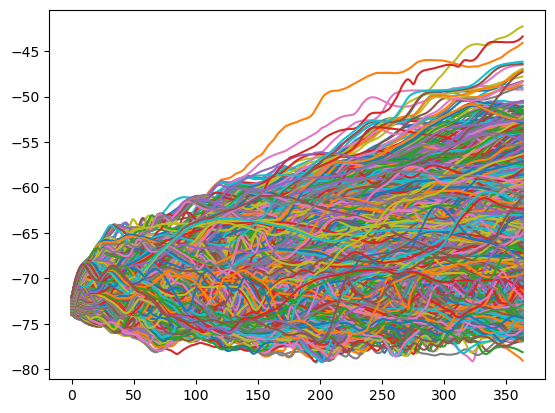

In [130]:
plt.plot(p1.lon[:,:].T)

In [131]:
p1 

s = np.where(np.logical_and(p1.lon[:,0]==-73, p1.lat[:,0]==36))[0]

In [132]:
centered_lon = -73
centered_lat = 36
delta_deg = 1/32

lon_conditional = np.logical_and(p1.lon[:,0]>=-73-1/32, p1.lon[:,0]<=-73 + 1/32)
lat_conditional = np.logical_and(p1.lat[:,0]>=36-1/32, p1.lat[:,0]<=36 + 1/32)
s = np.where(np.logical_and(lon_conditional, lat_conditional))[0]

In [133]:
def neighbour_particles(pset, lon, lat, delta_deg):
    """
    Function to find the particles in a certain radius around a point
    pset: xarray dataset with the particle data
    lon: longitude of the point
    lat: latitude of the point
    delta_deg: radius around the point in degrees
    
    Returns: the indexes of the particles in the radius around the point
    """
    
    lon_conditional = np.logical_and(pset.lon[:,0]>=lon-delta_deg, pset.lon[:,0]<=lon + delta_deg)
    lat_conditional = np.logical_and(pset.lat[:,0]>=lat-delta_deg, pset.lat[:,0]<=lat + delta_deg)
    s = np.where(np.logical_and(lon_conditional, lat_conditional))[0]
    return s

In [134]:
centered_lon = -73
centered_lat = 36
delta_deg = 0

indexes = neighbour_particles(p1, centered_lon, centered_lat, delta_deg)

In [135]:
indexes

array([2080])

In [136]:
p2 = p1.isel(trajectory=indexes)

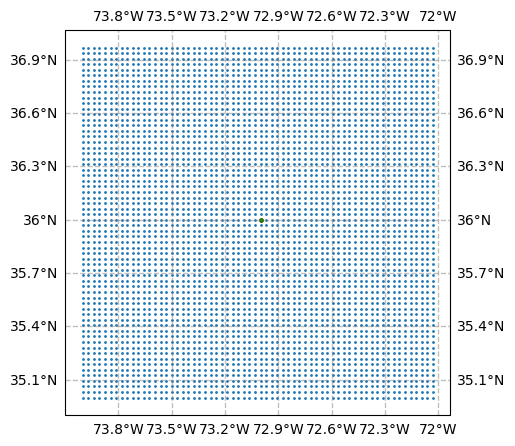

In [137]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# ax.set_extent([-90, -60, 25, 50])
# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(p1.lon[:,0], p1.lat[:,0], s=1)
pp = 2**5 + 2**11

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='r')

plt.scatter(p2.lon[:,0], p2.lat[:,0], s=5, c='g')


# Building the PDF 

# 1. Cross-ensemble 1 particle distribution
We take the same particle at the surface for all 50 member ensemble and build two PDFs.
1. 𝑝(𝑿(𝑡 + 𝜏)−𝑿(𝑡) | 𝑿(𝑡), 𝑡, 𝜏),
where $\vec{X}(t)$ is the position of the particles at time $t$ and $\vec{X}(t + \tau)$ is the position of the particle after $\tau$.

2. Probability of following similar path.


In [423]:
skip_member = 23

member = 1
path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
pset_member = xr.open_zarr(path)
pset_member = pset_member.isel(trajectory=level_indexes[100])

centered_lon = -73
centered_lat = 36
delta_deg = 1/32

particle_index = neighbour_particles(pset_member, centered_lon, centered_lat, delta_deg)
pset_member = pset_member.isel(trajectory=particle_index)

for member in tqdm(range(2,51)):
    if member == skip_member:
        continue
    else:
        path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
        pset_member_aux = xr.open_zarr(path)
        pset_member_aux = pset_member_aux.isel(trajectory=level_indexes[100])
        pset_member_aux = pset_member_aux.isel(trajectory=particle_index)
        
        pset_member = xr.concat([pset_member, pset_member_aux], dim='trajectory')
    
    

100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


In [424]:
pset_member

<xarray.Dataset> Size: 5MB
Dimensions:     (trajectory: 441, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 4kB 32241 32257 32273 ... 34289 34305 34321
Data variables:
    lat         (trajectory, obs) float64 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

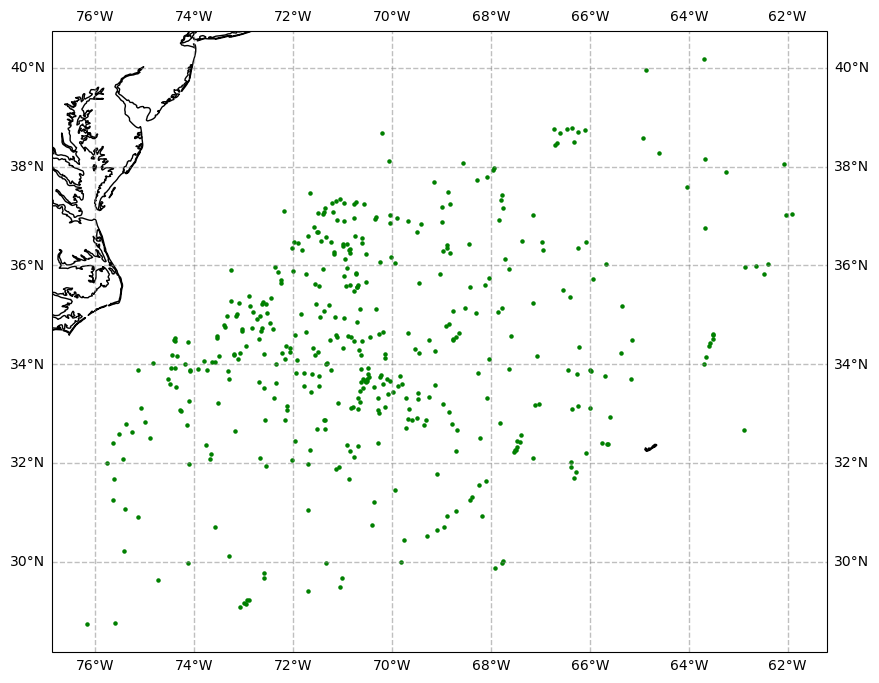

In [425]:
# plot the first 45 particles with land from cartopy
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.set_extent([-180, 180, -90, 90])

# for i in range(400):
# ax.plot(pset_member.lon[:, :].T, pset_member.lat[:, :].T);
tau = 100
ax.scatter(pset_member.lon[:,tau], pset_member.lat[:,tau], s=5, c='g')
# ax.set_title('Member 001 Jan-Dec 2010 | Surface release')

In [426]:
# Assuming you have arrays of longitude and latitude
tau = 3
lon = pset_member.lon[:,tau].values
lat = pset_member.lat[:,tau].values

# Stack the longitude and latitude arrays into a 2D array
particles = np.vstack([lon, lat]).T
particles *= np.pi / 180  # Convert degrees to radians

nx, ny = 81, 61
domain_limits = [[-80, -40], [15, 45]]

xgrid = np.linspace(domain_limits[0][0], domain_limits[0][1], nx)
ygrid = np.linspace(domain_limits[1][0], domain_limits[1][1], ny)

X, Y = np.meshgrid(xgrid, ygrid)

xy = np.vstack([X.ravel(), Y.ravel()]).T
xy *= np.pi / 180  # Convert degrees to radians


# # Create and fit the KernelDensity model
kde = KernelDensity(
        bandwidth=0.003, metric="haversine", kernel="gaussian", algorithm="ball_tree"
    )
kde.fit(particles)

Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

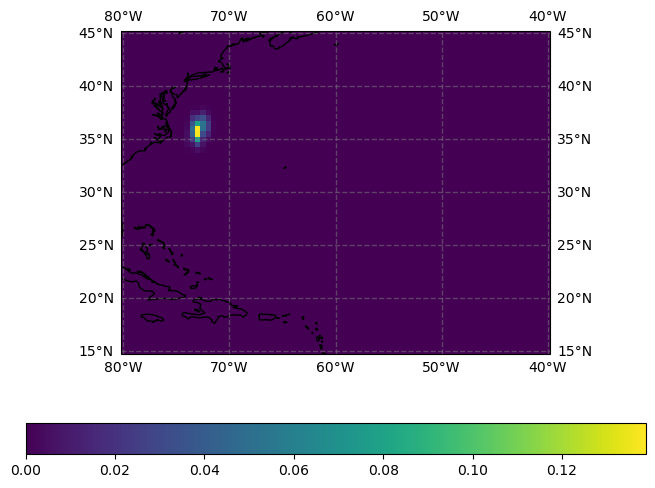

In [427]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# add Land and Ocean Features
ax.add_feature(cartopy.feature.LAND, edgecolor='black')

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
im = ax.pcolormesh(X, Y, Z/Z.sum())
fig.colorbar(im, orientation='horizontal')


In [428]:
def build_KDE(pset_member, tau, nx, ny, domain_limits, bandwidth=0.01):
    lon = pset_member.lon[:,tau].values
    lat = pset_member.lat[:,tau].values

    # Stack the longitude and latitude arrays into a 2D array
    particles = np.vstack([lon, lat]).T
    particles *= np.pi / 180  # Convert degrees to radians

    xgrid = np.linspace(domain_limits[0][0], domain_limits[0][1], nx)
    ygrid = np.linspace(domain_limits[1][0], domain_limits[1][1], ny)

    X, Y = np.meshgrid(xgrid, ygrid)

    xy = np.vstack([X.ravel(), Y.ravel()]).T
    xy *= np.pi / 180  # Convert degrees to radians

    # Create and fit the KernelDensity model
    kde = KernelDensity(
            bandwidth=bandwidth, metric="haversine", kernel="gaussian", algorithm="ball_tree"
        )
    kde.fit(particles)

    Z = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    Z = Z/Z.sum()
    
    return Z

In [429]:
nx, ny = 54, 41
domain_limits = [[-80, -40], [15, 45]]
time = 0

P = np.zeros((364, nx, ny))
P_kde = np.zeros((364, nx, ny))


for time in tqdm(range(0, 50)):
    p_aux, x_, y_ = np.histogram2d(pset_member.lon[:, time].T, pset_member.lat[:, time].T, bins=[nx, ny], range=domain_limits, density=True)
    P[time] = p_aux

    Z = build_KDE(pset_member, time, nx, ny, domain_limits, bandwidth=0.004)
    P_kde[time] = Z.T

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


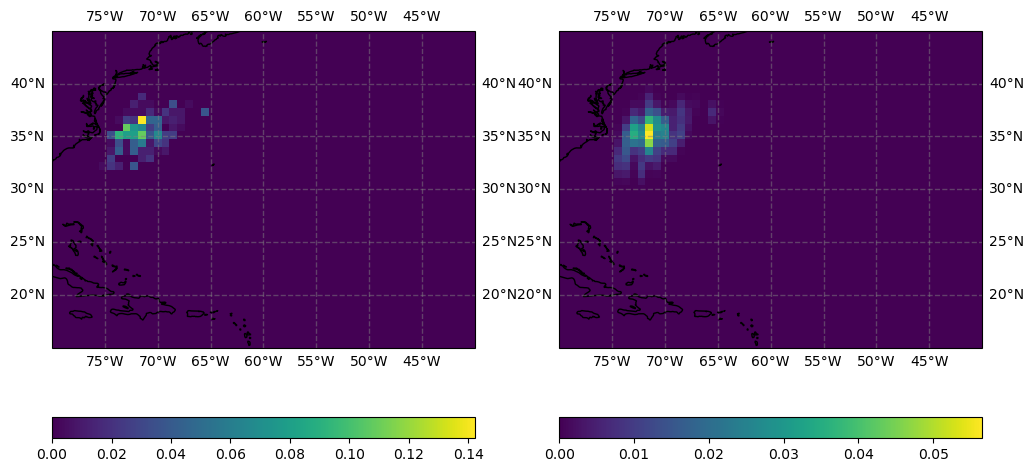

In [430]:
#plot P and P_kde in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
axs[0].coastlines()
axs[1].coastlines()

# add Land and Ocean Features
axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

tau = 30
im = axs[0].pcolormesh(x_, y_, P[tau].T)
fig.colorbar(im, ax=axs[0], orientation='horizontal')
im = axs[1].pcolormesh(x_, y_, P_kde[tau].T)
fig.colorbar(im, ax=axs[1], orientation='horizontal')


In [431]:
pset_1 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_023.zarr')
p1 = pset_1.isel(trajectory=level_indexes[100])

In [432]:
centered_lon = -73
centered_lat = 36
delta_deg = 1/3

indexes = neighbour_particles(p1, centered_lon, centered_lat, delta_deg)
pset_m1 = p1.isel(trajectory=indexes)

In [433]:
indexes.shape

(441,)

In [434]:
def compute_probabilities(pset, ntime, nx, ny, domain_limits, bandwidth=0.01):
    P = np.zeros((ntime, nx, ny))
    P_kde = np.zeros((ntime, nx, ny))

    for time in tqdm(range(0, ntime)):
        p_aux, x_, y_ = np.histogram2d(pset.lon[:, time].T, pset.lat[:, time].T, bins=[nx, ny], range=domain_limits, density=True)
        P[time] = p_aux

        Z = build_KDE(pset, time, nx, ny, domain_limits, bandwidth=bandwidth)
        P_kde[time] = Z.T
        
        P_kde[np.where(P_kde == 0)] = np.nan
        P[np.where(P == 0)] = np.nan
        
    return P, P_kde

In [435]:
nx, ny = 54, 41
domain_limits = [[-80, -40], [15, 45]]

P_m1, P_kde_m1 = compute_probabilities(pset_m1, 364, nx, ny, domain_limits, bandwidth=0.004)

100%|██████████| 364/364 [00:21<00:00, 16.85it/s]


In [436]:
nx, ny = 54, 41
domain_limits = [[-80, -40], [15, 45]]

P, P_kde= compute_probabilities(pset_member, 364, nx, ny, domain_limits, bandwidth=0.004)

  0%|          | 0/364 [00:00<?, ?it/s]

100%|██████████| 364/364 [04:40<00:00,  1.30it/s]


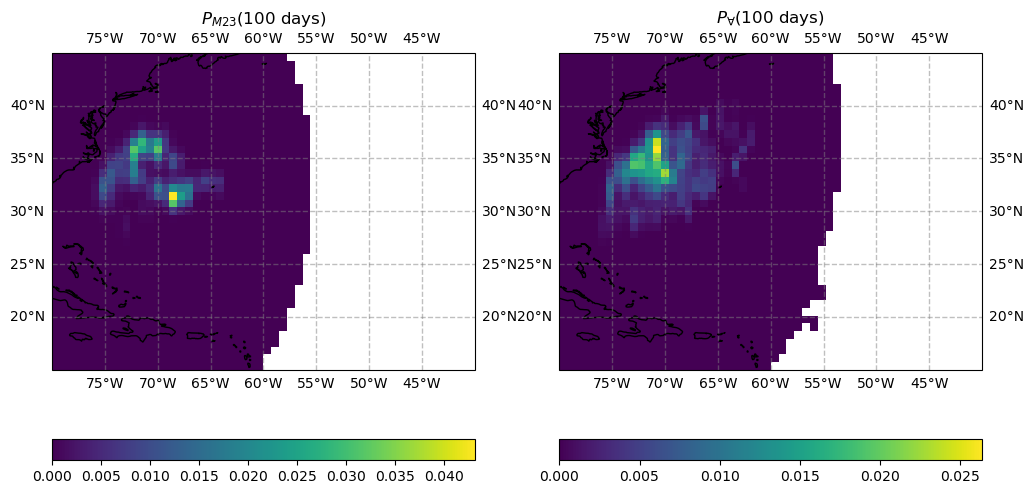

In [445]:
#plot P and P_kde in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
axs[0].coastlines()
axs[1].coastlines()

# add Land and Ocean Features
axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')


tau = 100


axs[0].set_title(r'$P_{M23}($' + f'{tau} days)')
axs[1].set_title(r'$P_{\forall}($' + f'{tau} days)')

im = axs[0].pcolormesh(x_, y_, P_kde_m1[tau].T)
fig.colorbar(im, ax=axs[0], orientation='horizontal')
im = axs[1].pcolormesh(x_, y_, P_kde[tau].T)
fig.colorbar(im, ax=axs[1], orientation='horizontal')



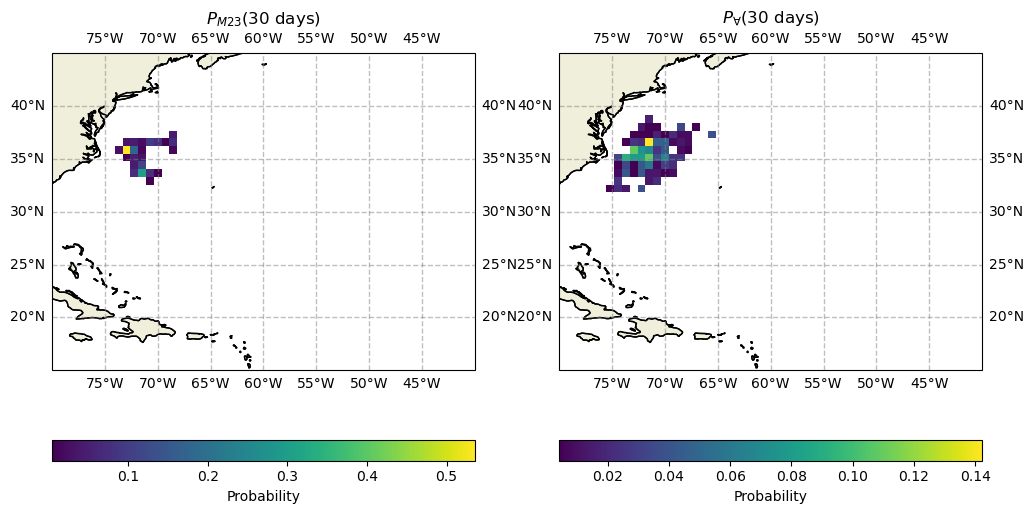

In [444]:
#plot P and P_kde in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
axs[0].coastlines()
axs[1].coastlines()

# add Land and Ocean Features
axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

tau = 30

axs[0].set_title(r'$P_{M23}($' + f'{tau} days)')
axs[1].set_title(r'$P_{\forall}($' + f'{tau} days)')

im = axs[0].pcolormesh(x_, y_, P_m1[tau].T)
fig.colorbar(im, ax=axs[0], orientation='horizontal', label='Probability')
im = axs[1].pcolormesh(x_, y_, P[tau].T)
fig.colorbar(im, ax=axs[1], orientation='horizontal', label='Probability')


In [446]:
# entropy
def entropy(Pdf):
    Pdf = Pdf/np.nansum(Pdf)
    return -np.nansum(Pdf*np.log(Pdf))

In [447]:
def kullback_leibler(P, Q):
    P = P/np.nansum(P)
    Q = Q/np.nansum(Q)
    return np.nansum(P*np.log(P/Q))

In [448]:
H_m1 = np.zeros(364)
H_mm = np.zeros(364)

D_m1 = np.zeros(364)
D_mm = np.zeros(364)

for i in range(364):
    H_m1[i] = entropy(P_m1[i])
    H_mm[i] = entropy(P[i])
    
    D_m1[i] = kullback_leibler(P_m1[i], P[i])
    D_mm[i] = kullback_leibler(P[i], P_m1[i])

Text(0, 0.5, 'Entropy (nats)')

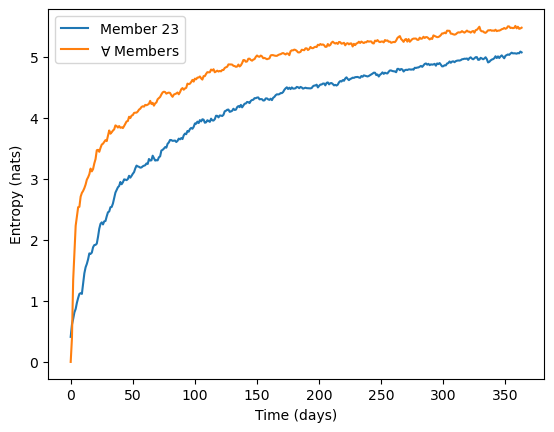

In [461]:
plt.plot(H_m1, label='Member 23')
plt.plot(H_mm, label=r'$\forall$ Members')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Entropy (nats)')

Text(0, 0.5, 'Information gain (nats)')

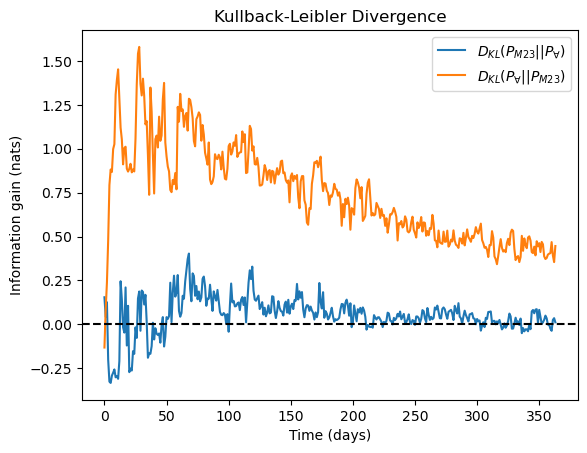

In [459]:
plt.plot(D_mm, label=r'$D_{KL} (P_{M23}||P_{\forall})$')
plt.plot(D_m1, label=r'$D_{KL} (P_{\forall}||P_{M23})$')
plt.axhline(0, color='k', linestyle='--')
plt.legend()
plt.title('Kullback-Leibler Divergence')
plt.xlabel('Time (days)')
plt.ylabel('Information Gain (nats)')